In [44]:
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pydicom import dcmread

In [18]:
dcm_file = "../data/1.2.826.0.2.139953.1.2.51872.44012.57444.5.dcm"
ds = dcmread(dcm_file)
print(ds)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Ophthalmic Photography 8 Bit Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.2.139953.1.2.51872.44012.57444.5
(0002,0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.214.1
(0002,0013) Implementation Version Name         SH: 'WIF 2.1.17'
(0002,0016) Source Application Entity Title     AE: 'OPTOS-EXPORT'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', '', 'COLOR', 'OPTOMAP', 'P200DTX', 'PLUS', '', '', 'PROJECTED', '']
(0008,0012) Instance Creation D

In [22]:
img = ds.pixel_array
print(img.shape)

(4000, 4000, 3)


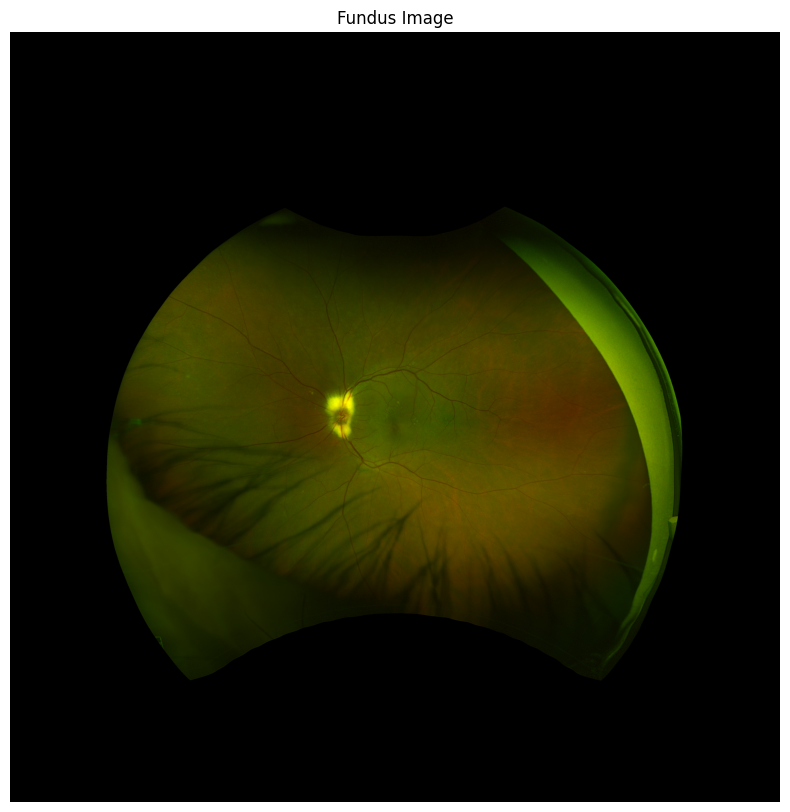

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Fundus Image")
plt.show()

In [36]:
with open("../data/1.2.826.0.2.139953.1.2.51872.44012.57444.5.json", "r") as f:
    data = json.load(f)

print("Key of JSON data:")
print("---------------------------------")
for k in data.keys():
    print(k)

Key of JSON data:
---------------------------------
version
flags
properties
shapes
lineColor
fillColor
imagePath
imageData
imageHeight
imageWidth


In [42]:
points = data['shapes'][0]['points']
print("Points of JSON data:")
print("---------------------------------")
for i in range(len(points)):
    print(points[i])
points = np.array(points)
points = np.round(points).astype(int)
print("Points of JSON data after rounding:")
print("---------------------------------")
for i in range(len(points)):
    print(points[i])

Points of JSON data:
---------------------------------
[1637.6267898000528, 2016.3151189395694]
[1624.097893914297, 1944.1610075488704]
[1664.684581571565, 1872.0068961581715]
[1732.329061000345, 1844.9491043866594]
[1813.5024363148814, 1890.0454240058464]
[1822.521700238719, 1980.2380632442198]
[1772.9157486576132, 2120.036654063699]
[1736.8386929622638, 2129.0559179875363]
Points of JSON data after rounding:
---------------------------------
[1638 2016]
[1624 1944]
[1665 1872]
[1732 1845]
[1814 1890]
[1823 1980]
[1773 2120]
[1737 2129]


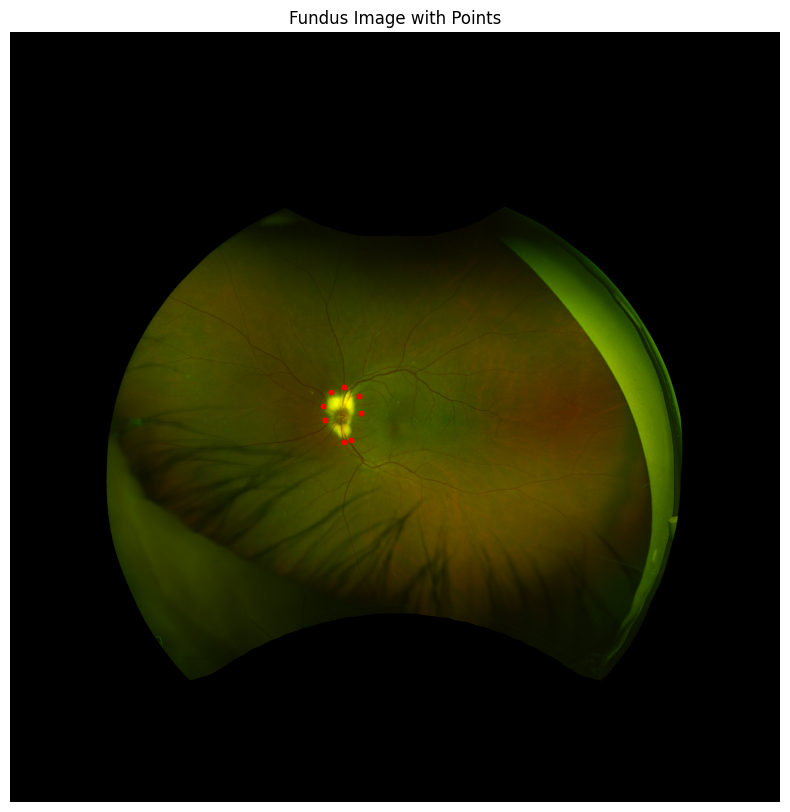

In [43]:
# Plot the points on the image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Fundus Image with Points")
plt.scatter(points[:, 0], points[:, 1], c='red', s=10)
plt.show()

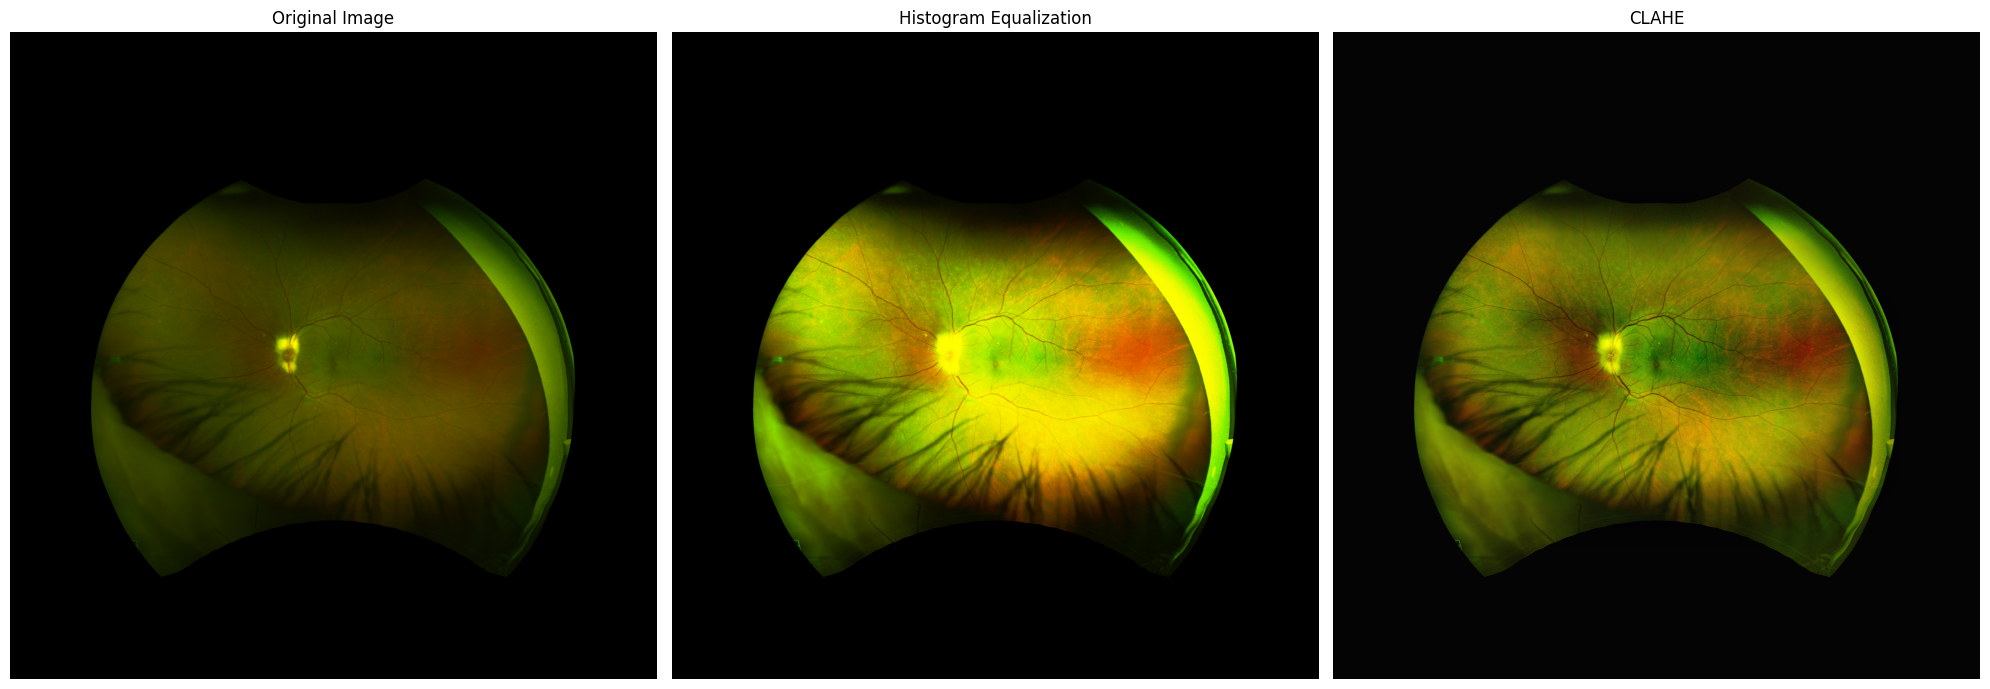

In [50]:
def apply_histeql_rgb(img):
    """
    Apply histogram equalization to each channel of an RGB image.
    """
    # Split the image into its RGB channels
    b, g, r = cv2.split(img)

    # Apply histogram equalization to each channel
    eq_b = cv2.equalizeHist(b)
    eq_g = cv2.equalizeHist(g)
    eq_r = cv2.equalizeHist(r)

    # Merge the channels back together
    eq_img = cv2.merge((eq_b, eq_g, eq_r))

    return eq_img


def apply_CLAHE_rgb(img):
    """
    Apply CLAHE to each channel of an RGB image.
    """
    # Split the image into its RGB channels
    b, g, r = cv2.split(img)

    # Create a CLAHE object (Arguments are optional)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))

    # Apply CLAHE to each channel
    cl_b = clahe.apply(b)
    cl_g = clahe.apply(g)
    cl_r = clahe.apply(r)

    # Merge the channels back together
    cl_img = cv2.merge((cl_b, cl_g, cl_r))

    return cl_img

histeql_img = apply_histeql_rgb(img)
clahed_img = apply_CLAHE_rgb(img)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(img)
axs[0].axis("off")
axs[0].set_title("Original Image")
axs[1].imshow(histeql_img)
axs[1].axis("off")
axs[1].set_title("Histogram Equalization")
axs[2].imshow(clahed_img)
axs[2].axis("off")
axs[2].set_title("CLAHE")
plt.tight_layout()
plt.show()

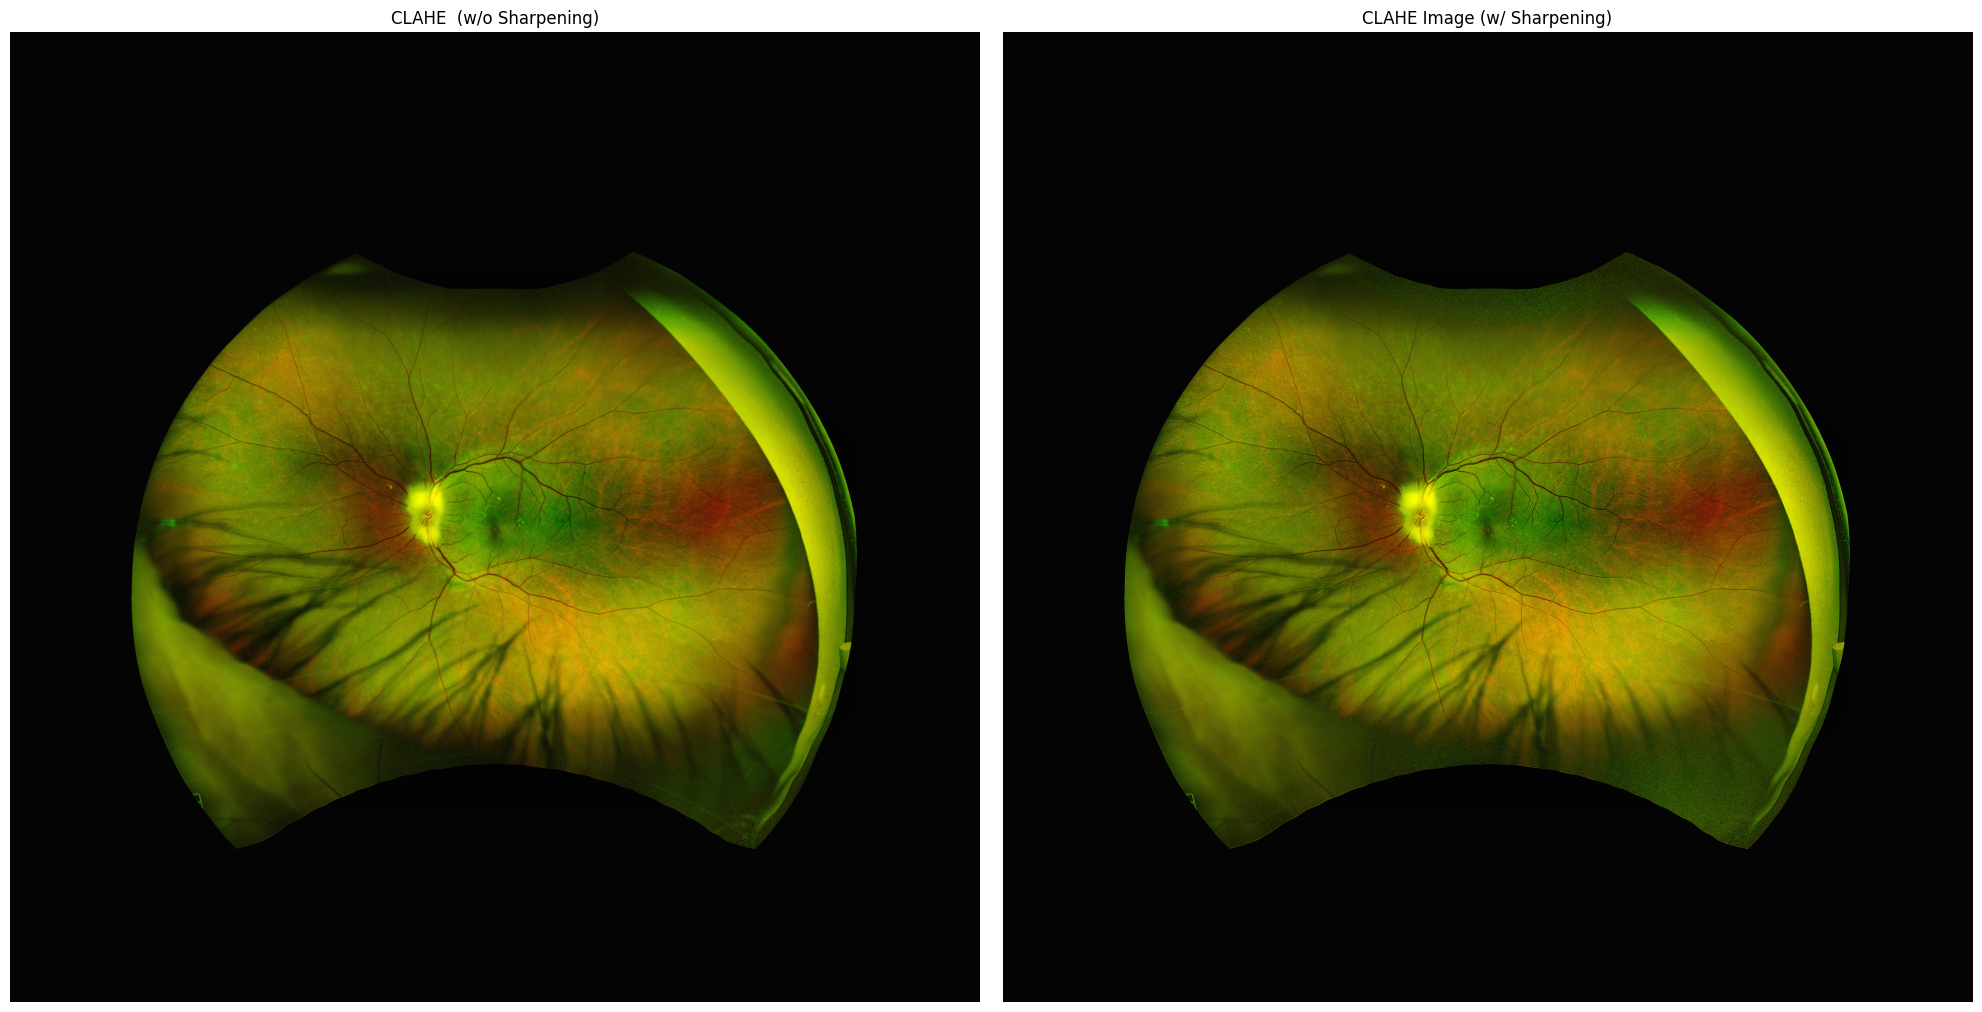

In [55]:
# Apply sharpening filter to clahed image
def sharpen_image(image):
    """
    Apply a sharpening filter to the image.
    """
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

sharpened_img = sharpen_image(clahed_img)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(clahed_img)
axs[0].axis("off")
axs[0].set_title("CLAHE  (w/o Sharpening)")
axs[1].imshow(sharpened_img)
axs[1].axis("off")
axs[1].set_title("CLAHE Image (w/ Sharpening)")
plt.tight_layout()
plt.show()

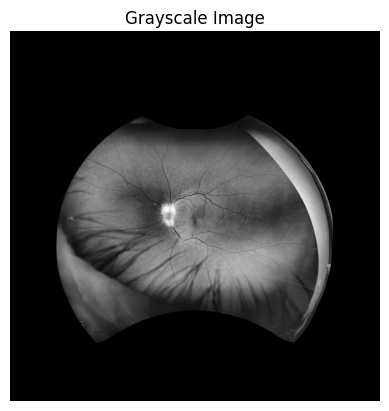

In [56]:
# Convert the image to grayscale
gray_img = cv2.cvtColor(clahed_img, cv2.COLOR_BGR2GRAY)

plt.Figure(figsize=(10, 10))
plt.imshow(gray_img, cmap='gray')
plt.axis("off")
plt.title("Grayscale Image")
plt.show()

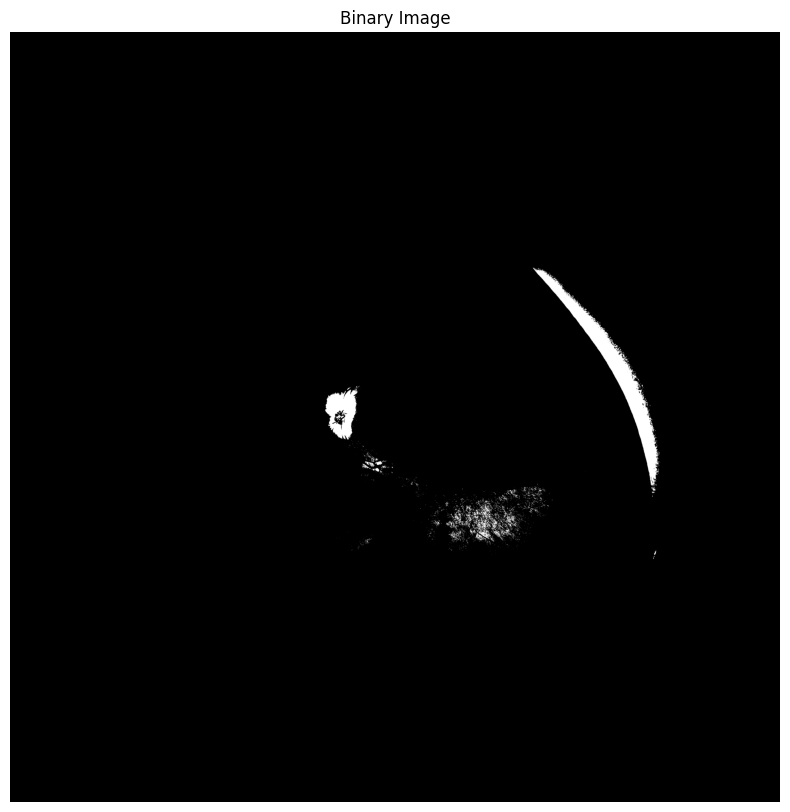

In [59]:
# Apply binary thresholding
_, binary_img = cv2.threshold(gray_img, 125, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.imshow(binary_img, cmap='gray')
plt.axis("off")
plt.title("Binary Image")
plt.show()

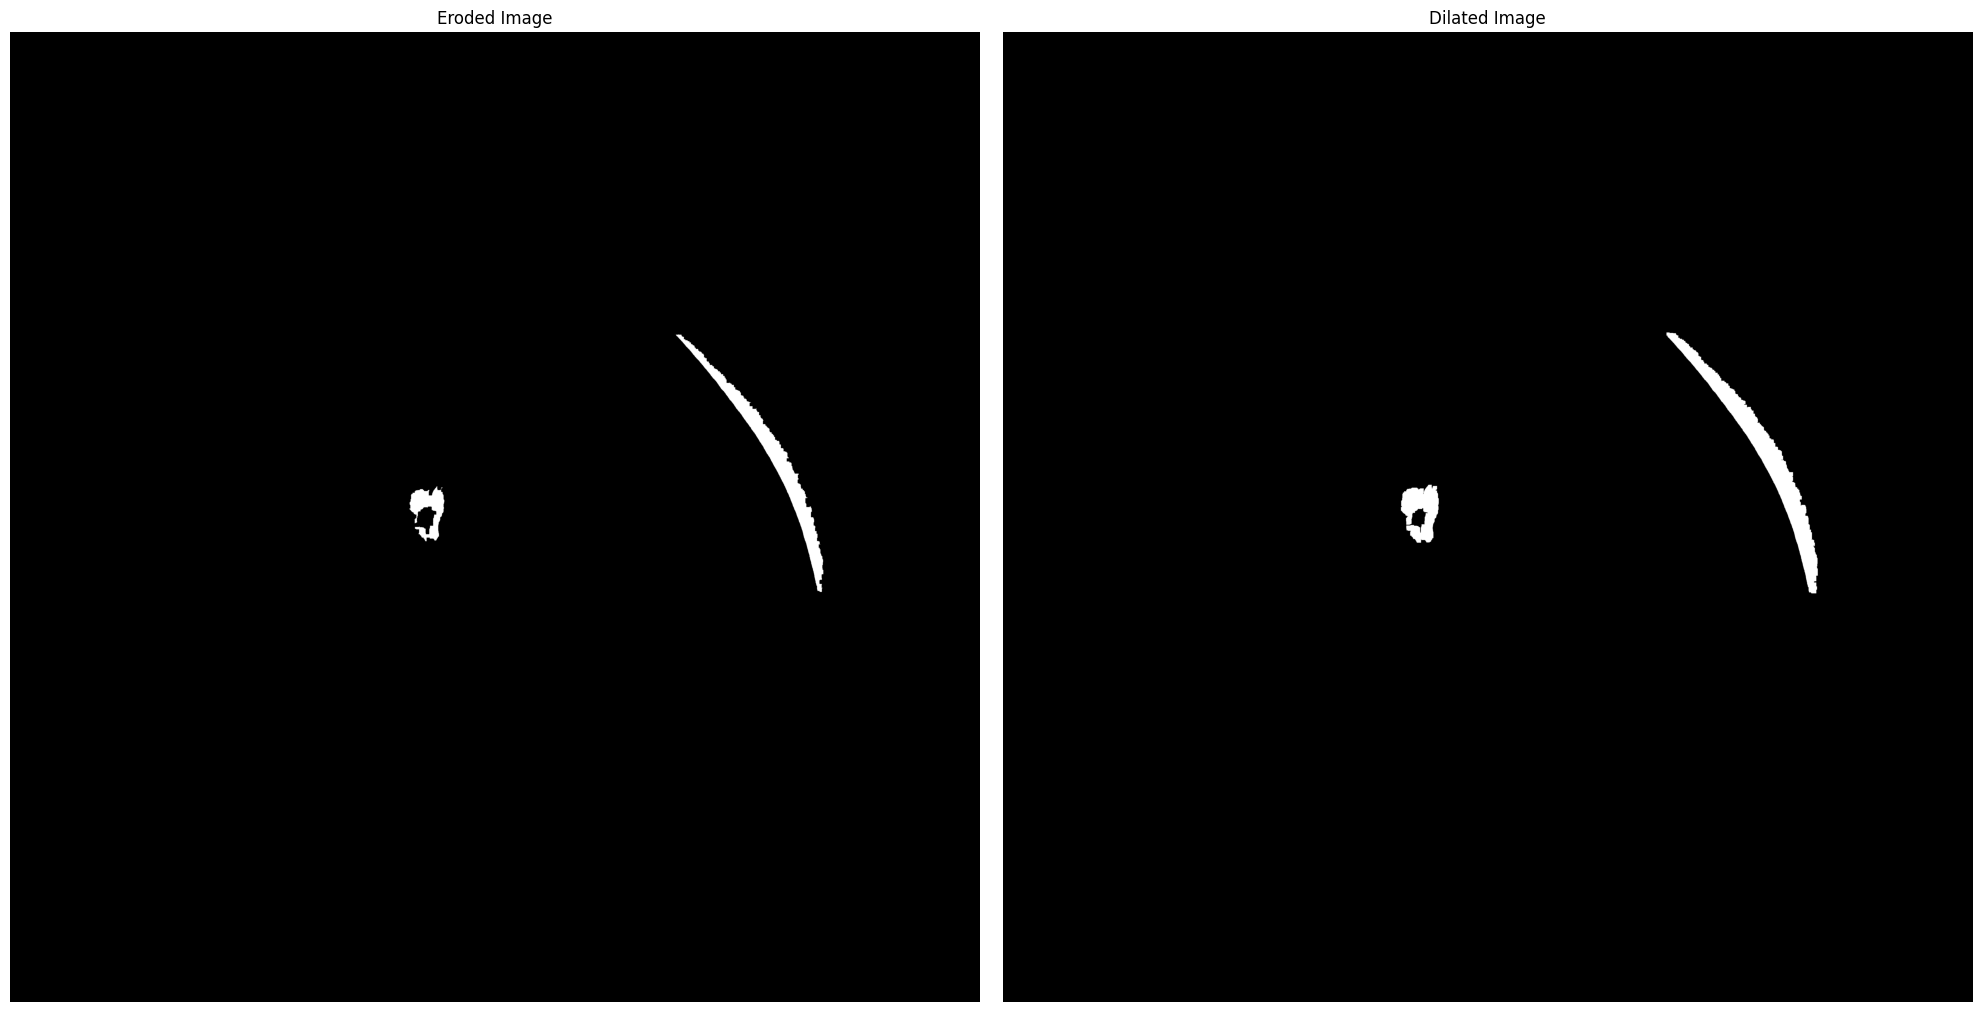

In [63]:
# Apply erosion and dilation
kernel = np.ones((7, 7), np.uint8)
eroded_img = cv2.erode(binary_img, kernel, iterations=2)
dilated_img = cv2.dilate(eroded_img, kernel, iterations=2)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(eroded_img, cmap='gray')
plt.axis("off")
plt.title("Eroded Image")
plt.subplot(1, 2, 2)
plt.imshow(dilated_img, cmap='gray')
plt.axis("off")
plt.title("Dilated Image")
plt.tight_layout()
plt.show()